In [1]:
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np

In [14]:
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
user_min_time = events_data.groupby('user_id',as_index=False).agg({'timestamp':'min'}). \
rename({'timestamp':'min_timestamp'},axis=1)
treshold = 2*24*60*60
user_min_time['min+2'] = user_min_time.min_timestamp + treshold
user_min_time = user_min_time.drop(['min_timestamp'], axis=1)
events_data_2 = events_data.merge(user_min_time, on='user_id', how='outer')
events_data_final = events_data_2[events_data_2['timestamp'] <= events_data_2['min+2']]


In [18]:
sub_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')

In [19]:
alter_sub = sub_data.pivot_table(index='user_id', columns='submission_status', values='step_id',\
                                          aggfunc='count',fill_value=0).reset_index()
alter_sub['is_gone'] = alter_sub['correct'] >= 40
alter_sub = alter_sub.drop(['correct', 'wrong'],axis=1)

In [23]:
sub_min_time = sub_data.groupby('user_id',as_index=False).agg({'timestamp':'min'}). \
rename({'timestamp':'min_timestamp'},axis=1)
sub_min_time['min+2'] =  sub_min_time['min_timestamp'] + treshold
sub_min_time2 = sub_min_time.drop(['min_timestamp'], axis=1)
sub_data_2 = sub_data.merge(sub_min_time2, on='user_id', how='outer')
sub_data_final = sub_data_2[sub_data_2['timestamp'] <= sub_data_2['min+2']]

In [28]:
new_event = events_data_final.pivot_table(index='user_id', columns='action', values='step_id',\
                                          aggfunc='count',fill_value=0).reset_index()
new_sub = sub_data_final.pivot_table(index='user_id', columns='submission_status', values='step_id',\
                                          aggfunc='count',fill_value=0).reset_index()
final_train = new_event.merge(new_sub, on='user_id', how='outer')
final_train = final_train.fillna(0)  

In [29]:
final_train.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong
0,1,1,0,0,1,0.0,0.0
1,2,9,9,2,9,2.0,0.0
2,3,15,15,4,20,4.0,4.0
3,5,1,1,0,1,2.0,2.0
4,7,1,1,0,1,0.0,0.0


In [34]:
final_train = final_train.merge(alter_sub, on='user_id', how='outer')
final_train = final_train.fillna(False)

In [41]:
final_train = final_train.drop(['is_gone_x'],axis=1)

In [44]:
final_train =final_train.rename(columns={'is_gone_y': 'is_gone'})

In [54]:
final_train['correct_ratio'] = final_train.correct / (final_train.correct + final_train.wrong)

In [56]:
final_train = final_train.fillna(0)

In [58]:
final_train = final_train.set_index(final_train.user_id)

In [60]:
X_train = final_train.drop(['user_id', 'is_gone'], axis=1)
y_train = final_train.is_gone.map(int).to_frame()

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [65]:
clf = RandomForestClassifier(random_state=0)
parametrs = {'n_estimators': range(1,8), 'max_depth': range(1, 6), 'min_samples_leaf': range(1,7), 
             'min_samples_split': range(2,11,2)}
grid_search = GridSearchCV(clf, parametrs, cv=4, n_jobs=-1)

In [70]:
grid_search.fit(X_train, y_train)

C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': range(1, 8), 'max_depth': range(1, 6), 'min_samples_leaf': range(1, 7), 'min_samples_split': range(2, 11, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [71]:
grid_search.best_params_

{'max_depth': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 6}

In [72]:
best_clf = grid_search.best_estimator_

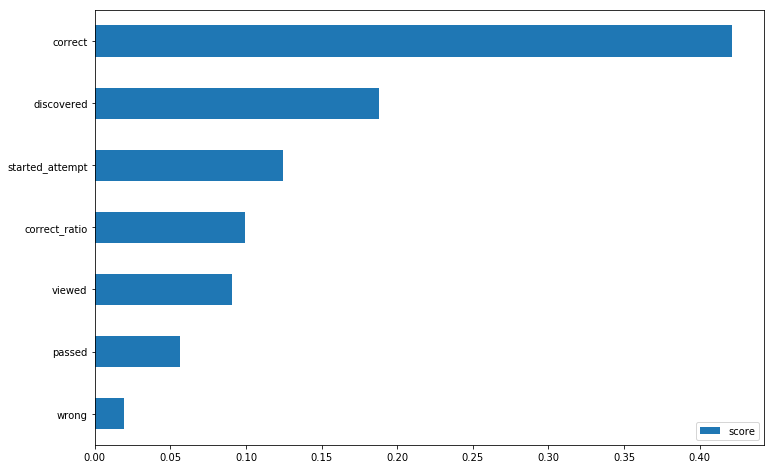

In [74]:
features = pd.DataFrame( best_clf.feature_importances_, index=X_train.columns, columns=['score'])
features.sort_values('score').plot(kind='barh', figsize=(12, 8))

In [75]:
sub_test = pd.read_csv("https://stepik.org/media/attachments/course/4852/submission_data_test.csv")
event_test = pd.read_csv("https://stepik.org/media/attachments/course/4852/events_data_test.csv")

In [76]:
new_event_test = event_test.pivot_table(index='user_id', columns='action', values='step_id',\
                                          aggfunc='count',fill_value=0).reset_index()
new_sub_test = sub_test.pivot_table(index='user_id', columns='submission_status', values='step_id',\
                                          aggfunc='count',fill_value=0).reset_index()

In [77]:
final_test = new_event_test.merge(new_sub_test, on='user_id', how='outer')
final_test = final_test.fillna(0)

In [79]:
final_test['correct_ratio'] = final_test.correct / (final_test.correct + final_test.wrong)

In [81]:
final_test = final_test.fillna(0)

In [82]:
final_test = final_test.set_index(final_test.user_id)

In [83]:
final_test.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,correct_ratio
user_id,,,,,,,,
4,4,1,1,0,1,0.0,0.0,0.000000
6,6,1,1,0,1,0.0,0.0,0.000000
10,10,2,2,0,6,0.0,0.0,0.000000
12,12,11,9,4,14,1.0,0.0,1.000000
13,13,70,70,35,105,29.0,36.0,0.446154


In [85]:
X_test = final_test.drop(['user_id'], axis=1)

In [87]:
X_test.shape

(6184, 7)

In [90]:
prediction = pd.DataFrame( best_clf.predict_proba(X_test), columns=['lose','win'])

In [91]:
prediction.head()

,lose,win
0,0.999982,0.000018
1,0.999982,0.000018
2,0.999982,0.000018
3,0.913705,0.086295
4,0.401902,0.598098


In [92]:
example =pd.read_csv('https://stepik.org/media/attachments/course/4852/submission_example.csv')

In [99]:
ids = final_test[['user_id']]

In [107]:
answer = ids.join(prediction)

In [108]:
answer.head()

,user_id,lose,win
user_id,,,
4,4,0.401902,0.598098
6,6,0.999982,0.000018
10,10,0.999982,0.000018
12,12,0.725080,0.274920
13,13,0.736261,0.263739


In [119]:
answer2 = pd.DataFrame({'user_id' : answer.user_id, 'is_gone': answer.win})

In [123]:
sub_test2 = pd.read_csv("https://stepik.org/media/attachments/course/4852/submission_data_test.csv")

In [128]:
new_sub_test2 = sub_test2.pivot_table(index='user_id', columns='submission_status', values='step_id',\
                                          aggfunc='count',fill_value=0).reset_index()
new_event_test2 = event_test.pivot_table(index='user_id', columns='action', values='step_id',\
                                          aggfunc='count',fill_value=0).reset_index()

In [129]:
final_test2 = new_event_test2.merge(new_sub_test2, on='user_id', how='outer')
final_test2 = final_test2.fillna(0)

In [130]:
final_test2.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong
0,4,1,1,0,1,0.0,0.0
1,6,1,1,0,1,0.0,0.0
2,10,2,2,0,6,0.0,0.0
3,12,11,9,4,14,1.0,0.0
4,13,70,70,35,105,29.0,36.0


In [131]:
ids2 = final_test2[['user_id']]

In [133]:
ids2.head()

,user_id
0,4
1,6
2,10
3,12
4,13


In [134]:
ids2.shape

(6184, 1)

In [137]:
ans = ids2.join(prediction.win).rename(columns={'win': 'is_gone'})

In [140]:
ans.head()

,user_id,is_gone
0,4,0.000018
1,6,0.000018
2,10,0.000018
3,12,0.086295
4,13,0.598098


In [141]:
ans.to_csv('answer_finall.csv')